# Dự đoán giá xe cũ sử dụng mô hình hồi quy tuyến tính

## Vấn đề:
Trong bài lab này, chúng ta sẽ xây dựng mô hình dự đoán giá xe hơi cũ dựa trên các đặc điểm của xe như năm sản xuất, số km đã đi, thông số động cơ, v.v.

## Mục tiêu:
- Phân tích các yếu tố ảnh hưởng đến giá bán của xe hơi cũ
- Xây dựng các mô hình hồi quy khác nhau để dự đoán giá xe
- So sánh hiệu suất của các mô hình để chọn ra mô hình tốt nhất

## Cách tiếp cận:
1. Đọc và tìm hiểu dữ liệu
2. Tiền xử lý dữ liệu
3. Phân tích dữ liệu và lựa chọn đặc trưng
4. Xây dựng các mô hình hồi quy tuyến tính
5. Đánh giá và so sánh các mô hình
6. Dự đoán trên dữ liệu kiểm tra

## Cài đặt thư viện cần thiết

In [19]:
# %pip install numpy
# %pip install pandas
# %pip install matplotlib
# %pip install seaborn
# %pip install scipy

## I. Đọc dữ liệu

In [1]:
from preprocessor.sklearn_preprocessor import preprocess_data
from featureEngineering.Visualizer import Visualizer
from featureEngineering.FeatureSelection import FeatureSelection

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = './data/'
data = pd.read_csv(path + 'train.csv')

In [3]:
print(f'Số lượng dòng của data: {len(data)}')
print(data.columns)

Số lượng dòng của data: 1647
Index(['Make', 'Model', 'Price', 'Year', 'Kilometer', 'Fuel Type',
       'Transmission', 'Location', 'Color', 'Owner', 'Seller Type', 'Engine',
       'Max Power', 'Max Torque', 'Drivetrain', 'Length', 'Width', 'Height',
       'Seating Capacity', 'Fuel Tank Capacity'],
      dtype='object')


In [4]:
data.head()

,Make,Model,Price,Year,Kilometer,Fuel Type,Transmission,Location,Color,Owner,Seller Type,Engine,Max Power,Max Torque,Drivetrain,Length,Width,Height,Seating Capacity,Fuel Tank Capacity
0,BMW,3-Series 320d,800000,2012,75576,Diesel,Automatic,Mumbai,White,Second,Individual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BMW,X1 sDrive20d xLine,2199000,2016,77000,Diesel,Automatic,Surat,Black,First,Individual,1995 cc,184 bhp @ 4000 rpm,350 Nm @ 1750 rpm,RWD,4454.0,2044.0,1545.0,5.0,63.0
2,Mahindra,XUV500 W4 1.99,800000,2017,112000,Diesel,Manual,Muzaffurpur,Silver,First,Individual,1997 cc,138 bhp @ 3750 rpm,320 Nm @ 1600 rpm,FWD,4585.0,1890.0,1785.0,7.0,70.0
3,Mercedes-Benz,GLS 400d 4MATIC,12900000,2021,3000,Diesel,Automatic,Delhi,White,First,Individual,2925 cc,326 bhp @ 3600 rpm,700 Nm @ 1200 rpm,AWD,5207.0,2157.0,1823.0,7.0,90.0
4,Toyota,Fortuner 2.8 4x2 AT [2016-2020],3499000,2019,73000,Diesel,Automatic,Mumbai,White,First,Individual,2755 cc,174 bhp @ 3400 rpm,450 Nm @ 1600 rpm,RWD,4795.0,1855.0,1835.0,7.0,80.0


#### Insights:
- Tập dữ liệu gồm 1647 mẫu với 20 đặc trưng (features)
- Các đặc trưng bao gồm thông tin về nhãn hiệu (Make), mẫu xe (Model), giá (Price), năm sản xuất (Year), số km đã đi (Kilometer), v.v.
- Có một số giá trị NaN trong dữ liệu, đặc biệt là trong các trường thông số kỹ thuật (Engine, Max Power, Max Torque)

## II. Tiền xử lý dữ liệu

### 1. Làm sạch dữ liệu

In [5]:
def clean_data(data):
    data["Engine"] = data["Engine"].str.replace(' cc', '', regex=False).astype(float)

    data[['Max Power BHP', 'Max Power RPM']] = data['Max Power'].str.extract(r'(\d+)\s*bhp\s*@\s*(\d+)\s*rpm')
    data['Max Power BHP'] = pd.to_numeric(data['Max Power BHP'], errors='coerce')
    data['Max Power RPM'] = pd.to_numeric(data['Max Power RPM'], errors='coerce')

    data[['Max Torque Nm', 'Max Torque RPM']] = data['Max Torque'].str.extract(r'(\d+)\s*Nm\s*@\s*(\d+)\s*rpm')
    data['Max Torque Nm'] = pd.to_numeric(data['Max Torque Nm'], errors='coerce')
    data['Max Torque RPM'] = pd.to_numeric(data['Max Torque RPM'], errors='coerce')

    rare_fuel_types = ['Electric', 'LPG', 'Hybrid', 'CNG + CNG', 'Petrol + LPG']
    data["Fuel Type"] = data["Fuel Type"].apply(lambda x: 'Others' if x in rare_fuel_types else x)

    drop_columns = ['Make', 'Model', 'Location', 'Color', 'Max Power', 'Max Torque']
    data.drop(drop_columns, axis=1, inplace=True)
    
    return data

In [6]:
data = clean_data(data)

#### Insights:
- Chuyển đổi các giá trị từ dạng text sang dạng số học:
  - Engine: Loại bỏ "cc" và chuyển thành kiểu float
  - Max Power: Tách thành công suất (BHP) và vòng tua (RPM)
  - Max Torque: Tách thành mô-men xoắn (Nm) và vòng tua (RPM)
- Nhóm các loại nhiên liệu hiếm vào một nhóm 'Others'
- Loại bỏ các cột ít liên quan hoặc có quá nhiều giá trị khác nhau như Make, Model, Location, Color

### 2. Phân chia và tiền xử lý dữ liệu

In [7]:
train_df, test_df, preprocessor, feature_names = preprocess_data(
    data=data,
    save_path='./processed_data/',
    train_ratio=0.7,
    test_ratio=0.3,
)

In [8]:
# Check if there are any columns with object type in the transformed dataframes
print("Train DataFrame Object Types:", train_df.select_dtypes(include=['object']).columns.tolist())
print("Test DataFrame Object Types:", test_df.select_dtypes(include=['object']).columns.tolist())

# If there are object columns, convert them to numeric
for df in [train_df, test_df]:
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = pd.to_numeric(df[col])

# Verify the conversion worked
print("\nAfter conversion:")
print("Train DataFrame Types:", train_df.dtypes.value_counts())
print("Test DataFrame Types:", test_df.dtypes.value_counts())

Train DataFrame Object Types: []
Test DataFrame Object Types: []

After conversion:
Train DataFrame Types: float64    22
Name: count, dtype: int64
Test DataFrame Types: float64    22
Name: count, dtype: int64


#### Insights:
- Dữ liệu được chia thành tập huấn luyện (70%) và tập kiểm tra (30%)
- Tất cả các cột đã được chuyển đổi sang kiểu số học (float64)
- Các biến phân loại (categorical) đã được mã hóa one-hot

## III. Mô hình hóa

### 1. Chọn các cột đặc trưng

#### Phân tích tương quan

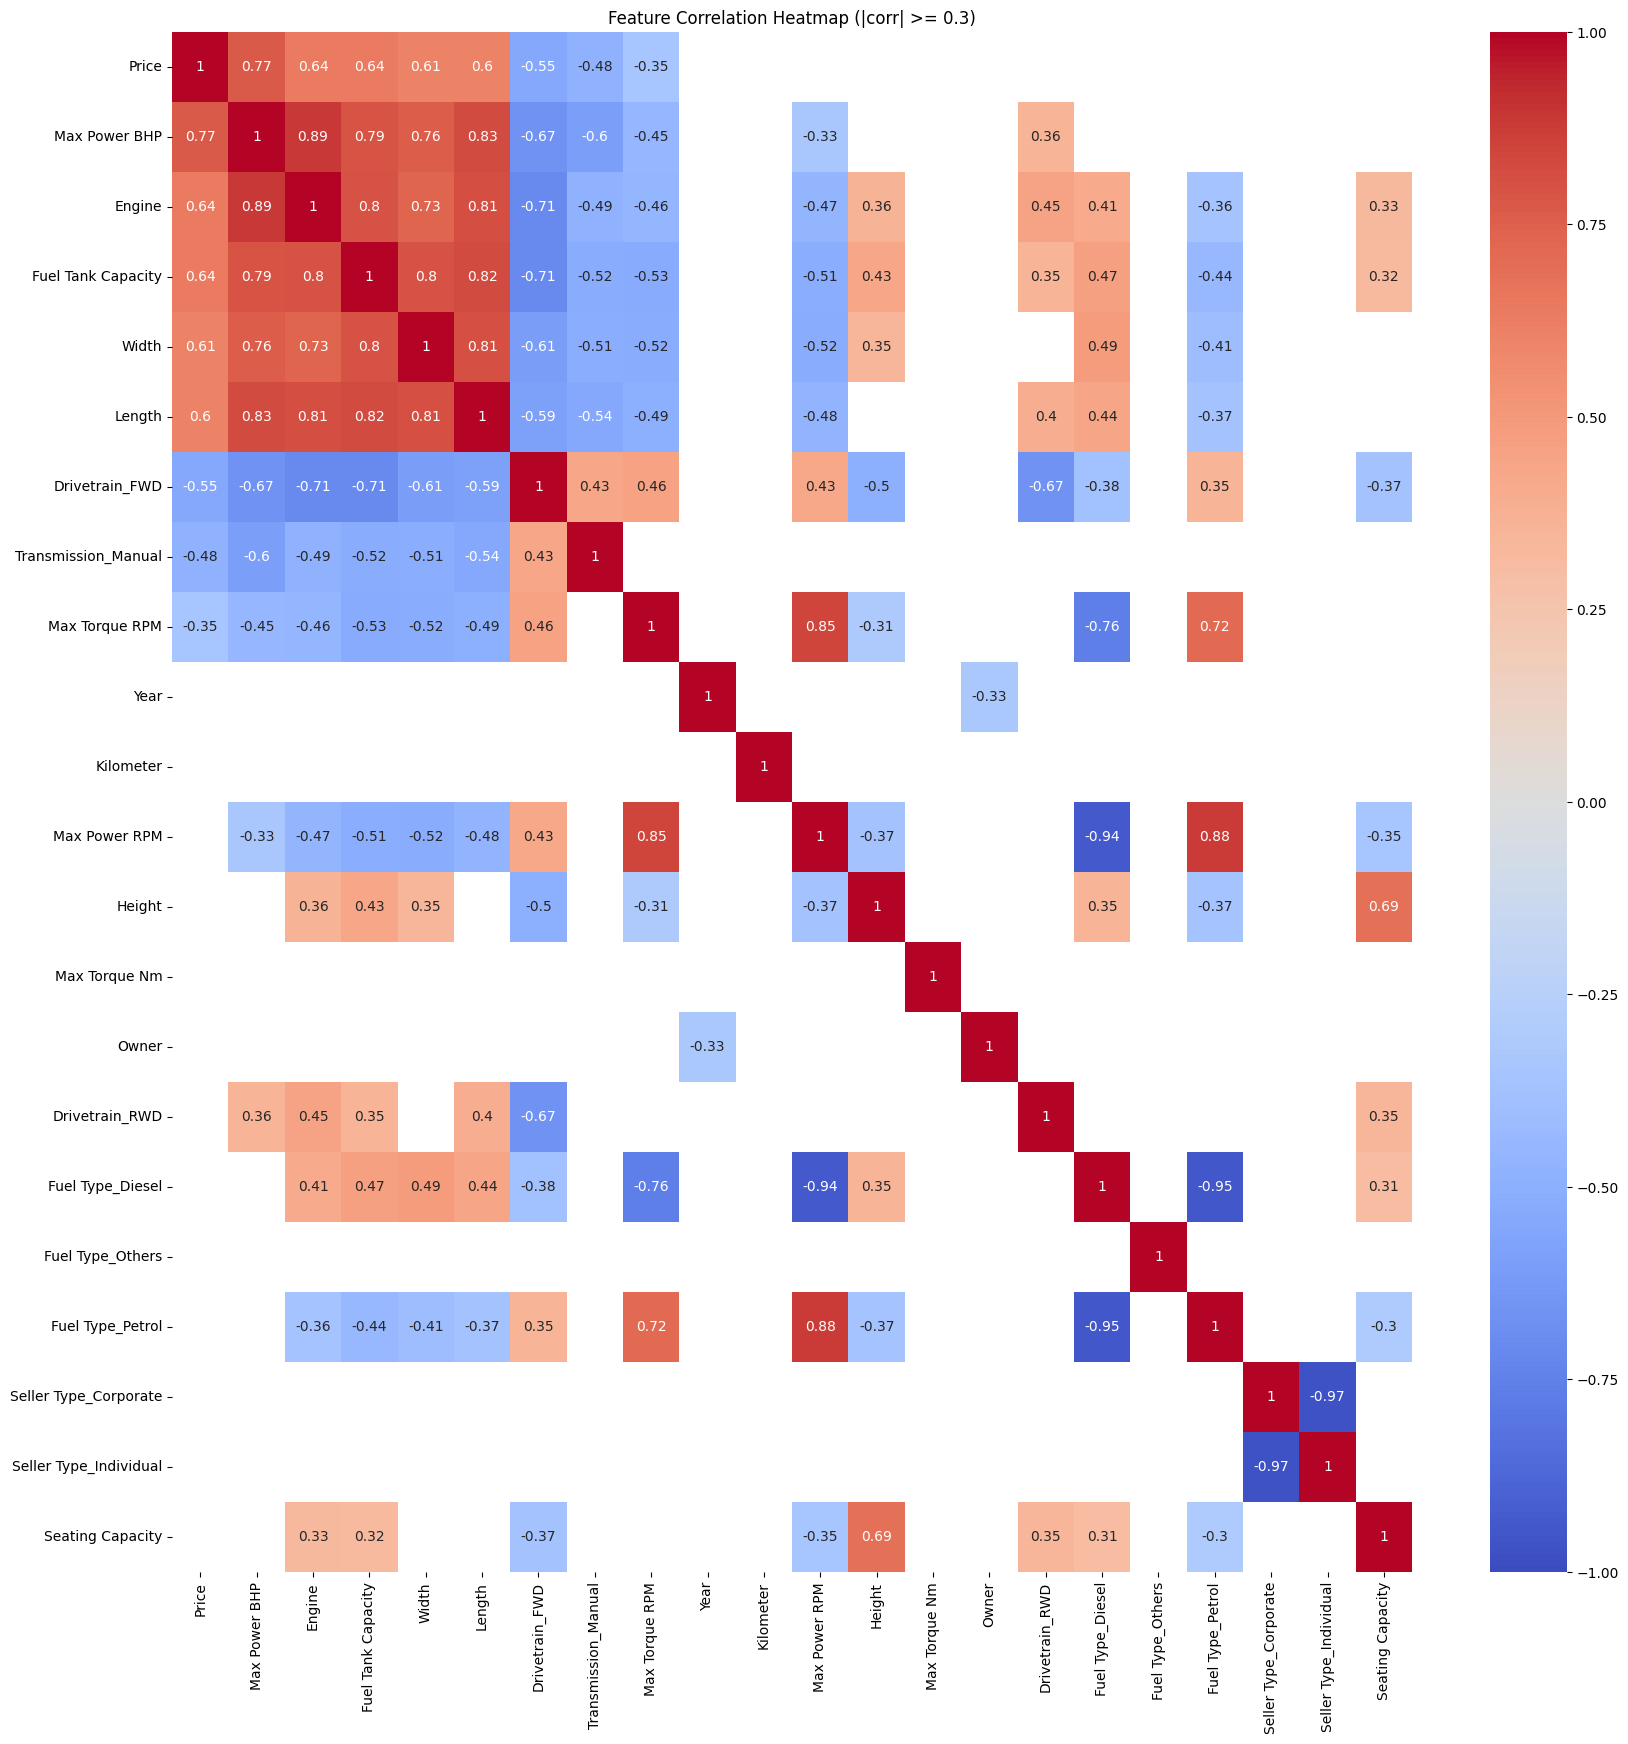

In [9]:
Visualizer.correlation_heatmap(train_df, min_correlation=0.3, target='Price')

In [10]:
from modelling.Model import StandardRegression, PolynomialRegression

oneHotCols = ['Drivetrain', 'Fuel Type', 'Seller Type', 'Transmission']
model_type = StandardRegression
model = model_type()

train = model.transform_features(train_df)
test = model.transform_features(test_df)
corr = train.corr()
sort_order = corr['Price'].abs().sort_values(ascending=False).index
sorted_corr = corr.loc[sort_order, sort_order]
subcols = sorted_corr.index.tolist()

# Chọn thử 14 cột có abs correlation >= 0.3 sau khi visualize
subcols = subcols[:9]
subtract = ['Price']
subcols = list(set(subcols) - set(subtract))
add = []
subcols = subcols + add
subcols

['Width',
 'Drivetrain_FWD',
 'Length',
 'Engine',
 'Transmission_Manual',
 'Fuel Tank Capacity',
 'Max Power BHP',
 'Max Torque RPM']

#### Insights:
- Từ biểu đồ nhiệt tương quan (correlation heatmap), chúng ta có thể thấy các đặc trưng có mối tương quan mạnh với giá xe (Price)
- Các đặc trưng được chọn dựa trên tương quan cao với biến mục tiêu (có độ lớn tương quan ≥ 0.3)
- Danh sách các đặc trưng quan trọng bao gồm: dung tích bình nhiên liệu, loại hộp số, hệ dẫn động, chiều rộng, dung tích động cơ, chiều dài, và công suất động cơ

In [11]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
def model_testing(subcols=None, linear=True, deg=2, auto_selection = True, 
            model_type=None, plot=True):
    if subcols is None:
        subcols = train_df.drop('Price', axis=1).columns.to_list()
    
    if linear:
        model = StandardRegression()
    else:
        model = model_type(degree=deg)

    train = model.transform_features(train_df.drop('Price', axis=1))
    test = model.transform_features(test_df.drop('Price', axis=1))
    train['Price'] = train_df['Price']
    test['Price'] = test_df['Price']

    # Forward selection
    if auto_selection:
        subcols, r2 = FeatureSelection.backward_elimination_mae(
            train[subcols + ['Price']],
            oneHotCols=oneHotCols,
            target='Price',
            model = model,
        )
        if plot:
            print('Best:', r2)
            print('Eliminated columns:', set(train.columns.to_list()) - set(subcols))
    
    print('Chosed columns: ', subcols)
    print('Total columns: ', len(subcols))
    if(plot):
        model.fit(train[subcols], train['Price'])
        y_train = train['Price']
        y_test = test['Price']
        y_train_pred = model.predict(train[subcols])
        y_test_pred = model.predict(test[subcols])

        # Evaluate after selecting features
        print('Train r^2: ', r2_score(y_train, y_train_pred))
        print('Train MAE: ', f"{mean_absolute_error(y_train, y_train_pred):.3e}")
        print('Train MSE: ', f"{mean_squared_error(y_train, y_train_pred):.3e}")
        print('Train RMSE: ', f"{np.sqrt(mean_squared_error(y_train, y_train_pred)):.3e}")

        print('Test r^2: ', r2_score(y_test, y_test_pred))
        print('Test MAE: ', f"{mean_absolute_error(y_test, y_test_pred):.3e}")
        print('Test MSE: ', f"{mean_squared_error(y_test, y_test_pred):.3e}")
        print('Test RMSE: ', f"{np.sqrt(mean_squared_error(y_test, y_test_pred)):.3e}")

        # diagnostic plots
        Visualizer.result_plots(y_train, y_train_pred, y_test, y_test_pred)
    return subcols

### 2. So sánh các mô hình

#### Hồi quy tuyến tính (sử dụng tất cả đặc trưng)

$$y =  \beta_0 + \sum \beta_j * x_j$$

Chosed columns:  ['Year', 'Kilometer', 'Max Power RPM', 'Max Torque RPM', 'Engine', 'Length', 'Height', 'Width', 'Fuel Tank Capacity', 'Max Power BHP', 'Max Torque Nm', 'Owner', 'Drivetrain_FWD', 'Drivetrain_RWD', 'Fuel Type_Diesel', 'Fuel Type_Others', 'Fuel Type_Petrol', 'Seller Type_Corporate', 'Seller Type_Individual', 'Transmission_Manual', 'Seating Capacity']
Total columns:  21
Train r^2:  0.8254446904882266
Train MAE:  3.757e+05
Train MSE:  1.119e+12
Train RMSE:  1.058e+06
Test r^2:  0.8933214939254925
Test MAE:  3.133e+05
Test MSE:  4.186e+11
Test RMSE:  6.470e+05


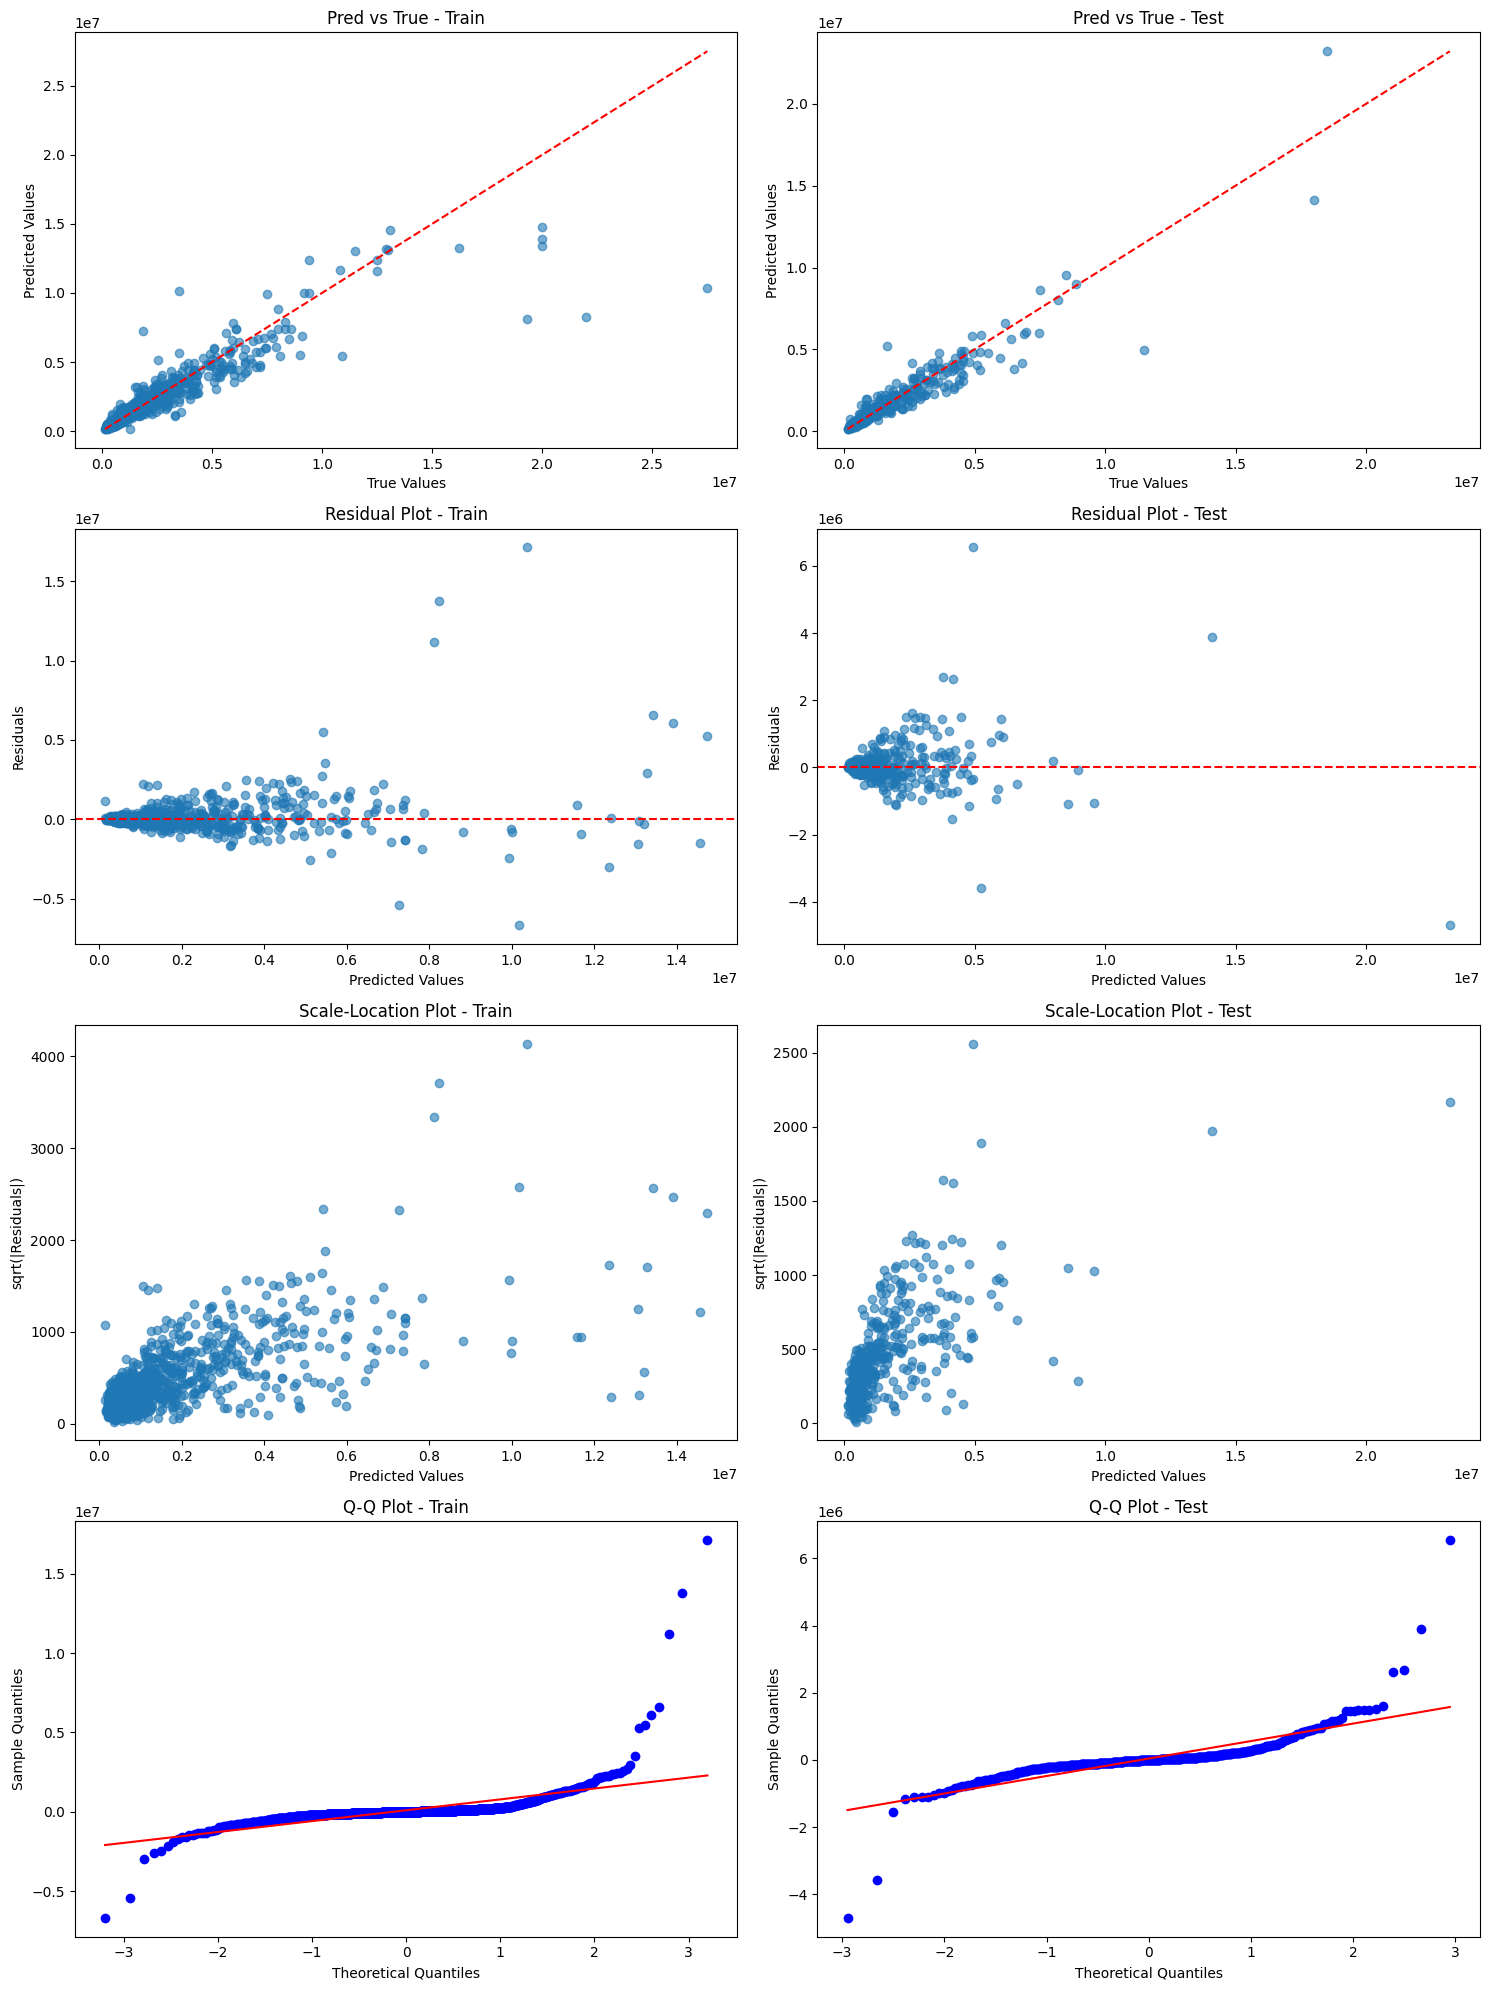

In [12]:
model_testing(auto_selection=False);

#### Insights:
- Mô hình sử dụng tất cả 21 đặc trưng
- R² cho tập huấn luyện: 0.825, tập kiểm tra: 0.893
- RMSE cho tập huấn luyện: 1.058e+06, tập kiểm tra: 6.470e+05
- Mô hình có khả năng dự đoán tốt trên cả tập huấn luyện và kiểm tra

#### Hồi quy tuyến tính (chỉ với các đặc trưng có |tương quan| > 0.3)


$$y =  \beta_0 + \sum_{j=1}^{8} \beta_j * x_j\\ \overline{1..8} \text{ is the subset of chosed columns} $$

Chosed columns:  ['Width', 'Drivetrain_FWD', 'Length', 'Engine', 'Transmission_Manual', 'Fuel Tank Capacity', 'Max Power BHP', 'Max Torque RPM']
Total columns:  8
Train r^2:  0.6718393093497013
Train MAE:  6.057e+05
Train MSE:  2.104e+12
Train RMSE:  1.450e+06
Test r^2:  0.7506754131509218
Test MAE:  5.104e+05
Test MSE:  9.784e+11
Test RMSE:  9.891e+05


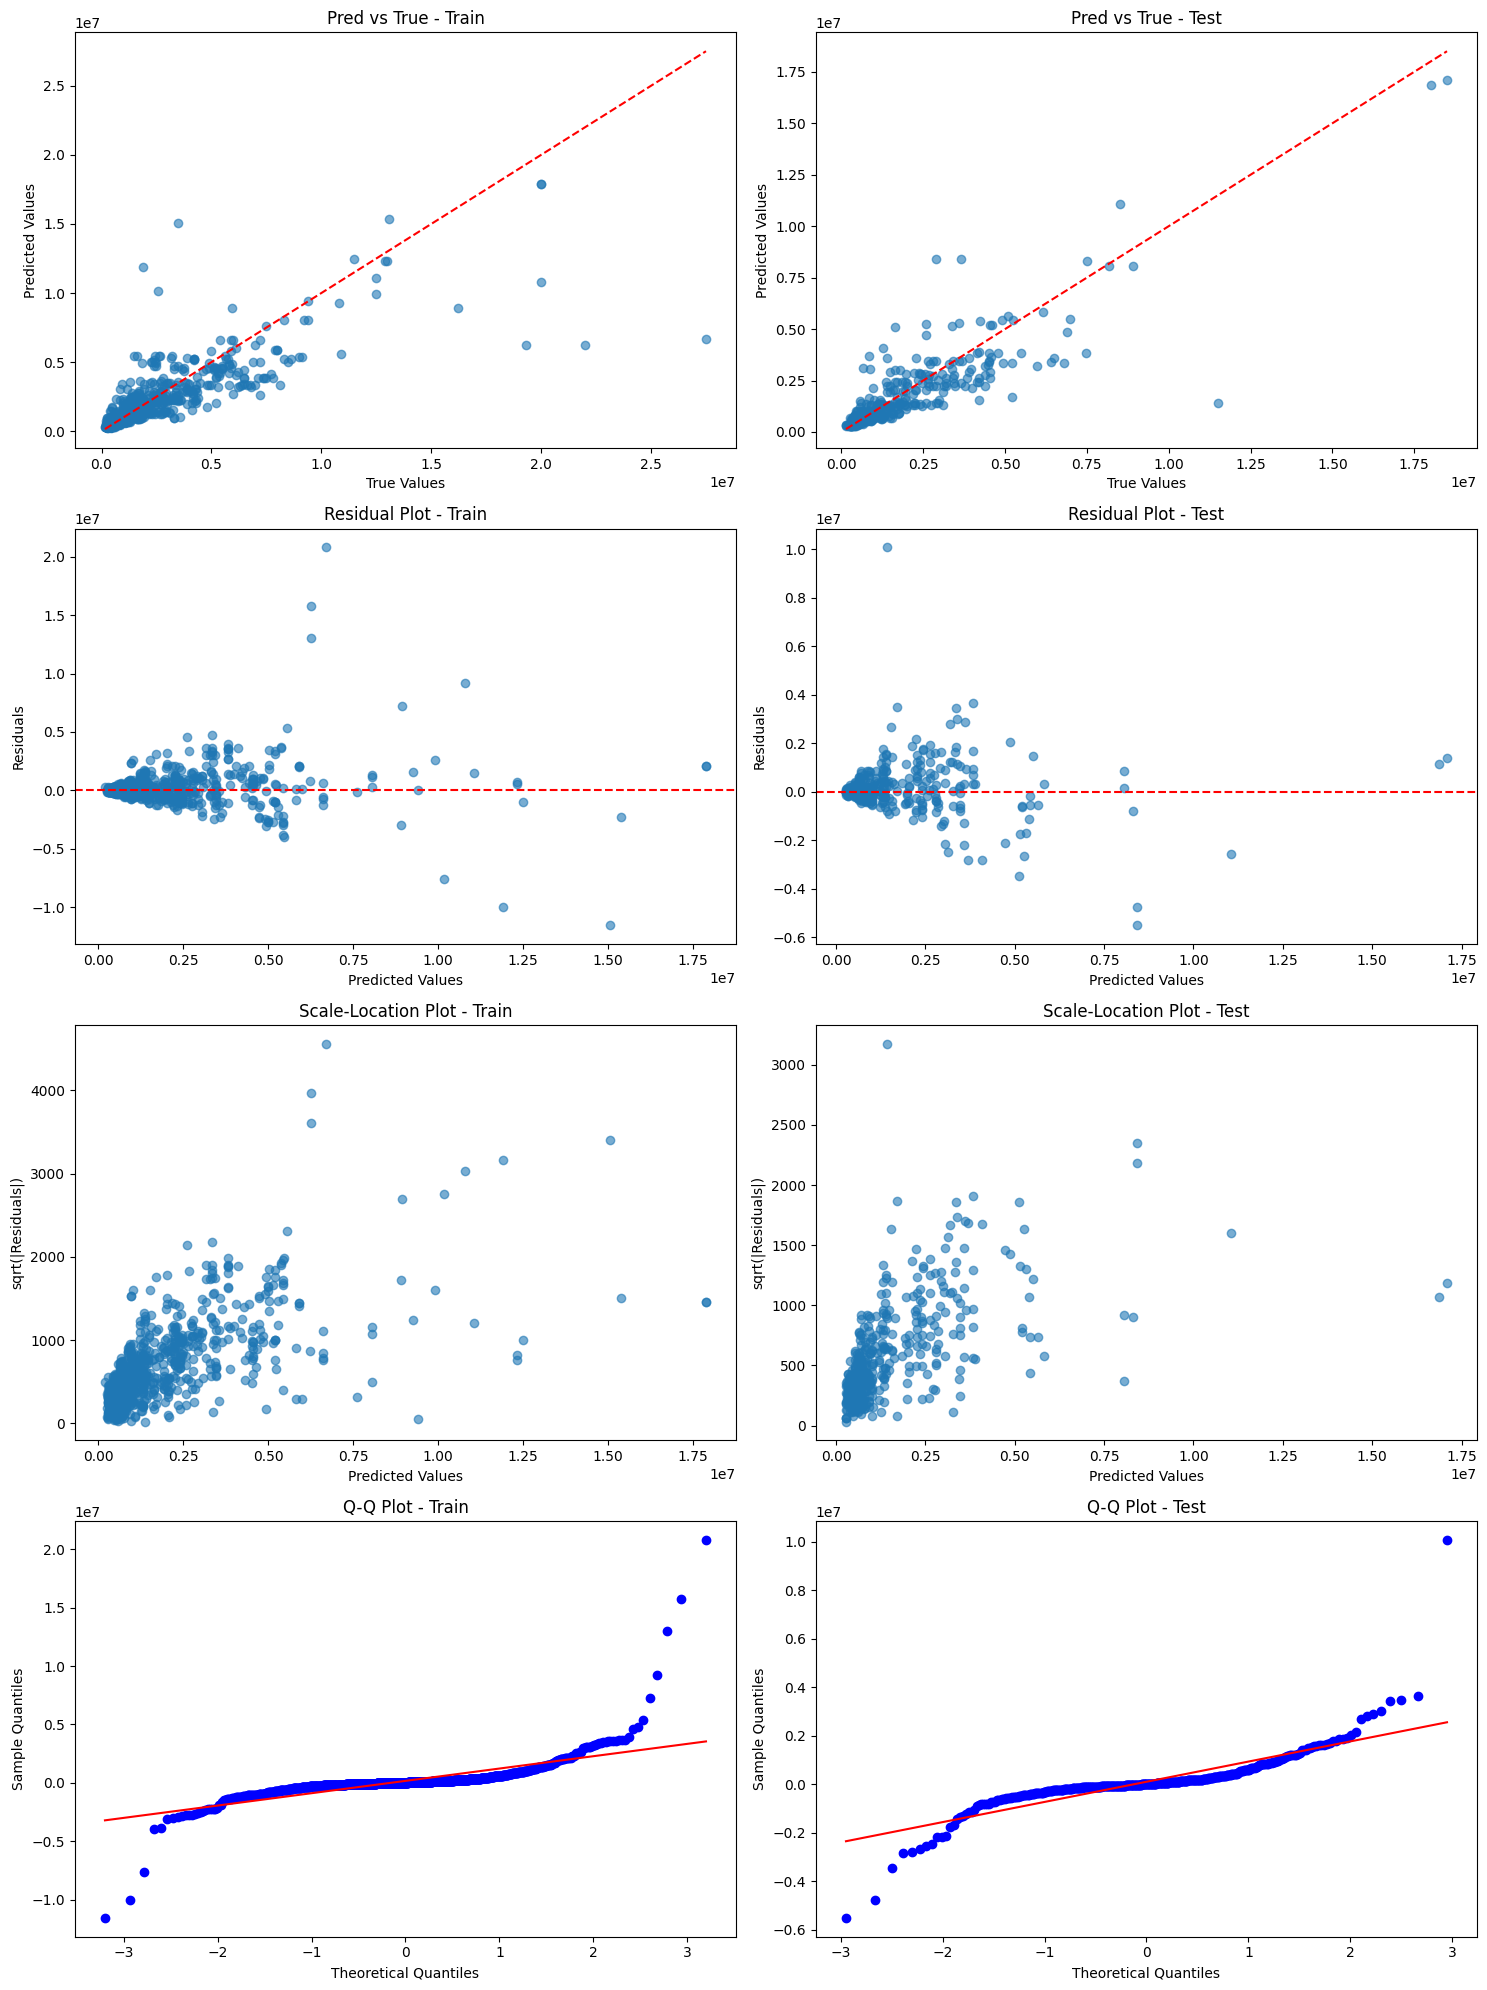

In [13]:
model_testing(subcols=subcols, linear=True, auto_selection=False);

#### Insights:
- Mô hình này chỉ sử dụng 7 đặc trưng: Fuel Tank Capacity, Transmission_Manual, Drivetrain_FWD, Width, Engine, Length, Max Power BHP
- R² cho tập huấn luyện: 0.667, tập kiểm tra: 0.720
- RMSE cao hơn so với mô hình sử dụng tất cả đặc trưng
- Đây là một mô hình đơn giản hơn nhưng vẫn có khả năng dự đoán khá tốt

#### Hồi quy tuyến tính với tự động lựa chọn đặc trưng

$$ y =  \beta_0 + \sum_{j=1}^n \beta_j * x_j\\ \overline{1..n} \text{ is the subset of chosed columns by performing feature selection on dataset $D$ (MAE metric)} $$

Best: 372947.3389839324
Eliminated columns: {'Price', 'Owner'}
Chosed columns:  ['Year', 'Kilometer', 'Max Power RPM', 'Max Torque RPM', 'Engine', 'Length', 'Height', 'Width', 'Fuel Tank Capacity', 'Max Power BHP', 'Max Torque Nm', 'Seating Capacity', 'Drivetrain_FWD', 'Drivetrain_RWD', 'Fuel Type_Diesel', 'Fuel Type_Others', 'Fuel Type_Petrol', 'Seller Type_Corporate', 'Seller Type_Individual', 'Transmission_Manual']
Total columns:  20
Train r^2:  0.8293480589701573
Train MAE:  3.729e+05
Train MSE:  1.094e+12
Train RMSE:  1.046e+06
Test r^2:  0.8924786626658949
Test MAE:  3.145e+05
Test MSE:  4.219e+11
Test RMSE:  6.496e+05


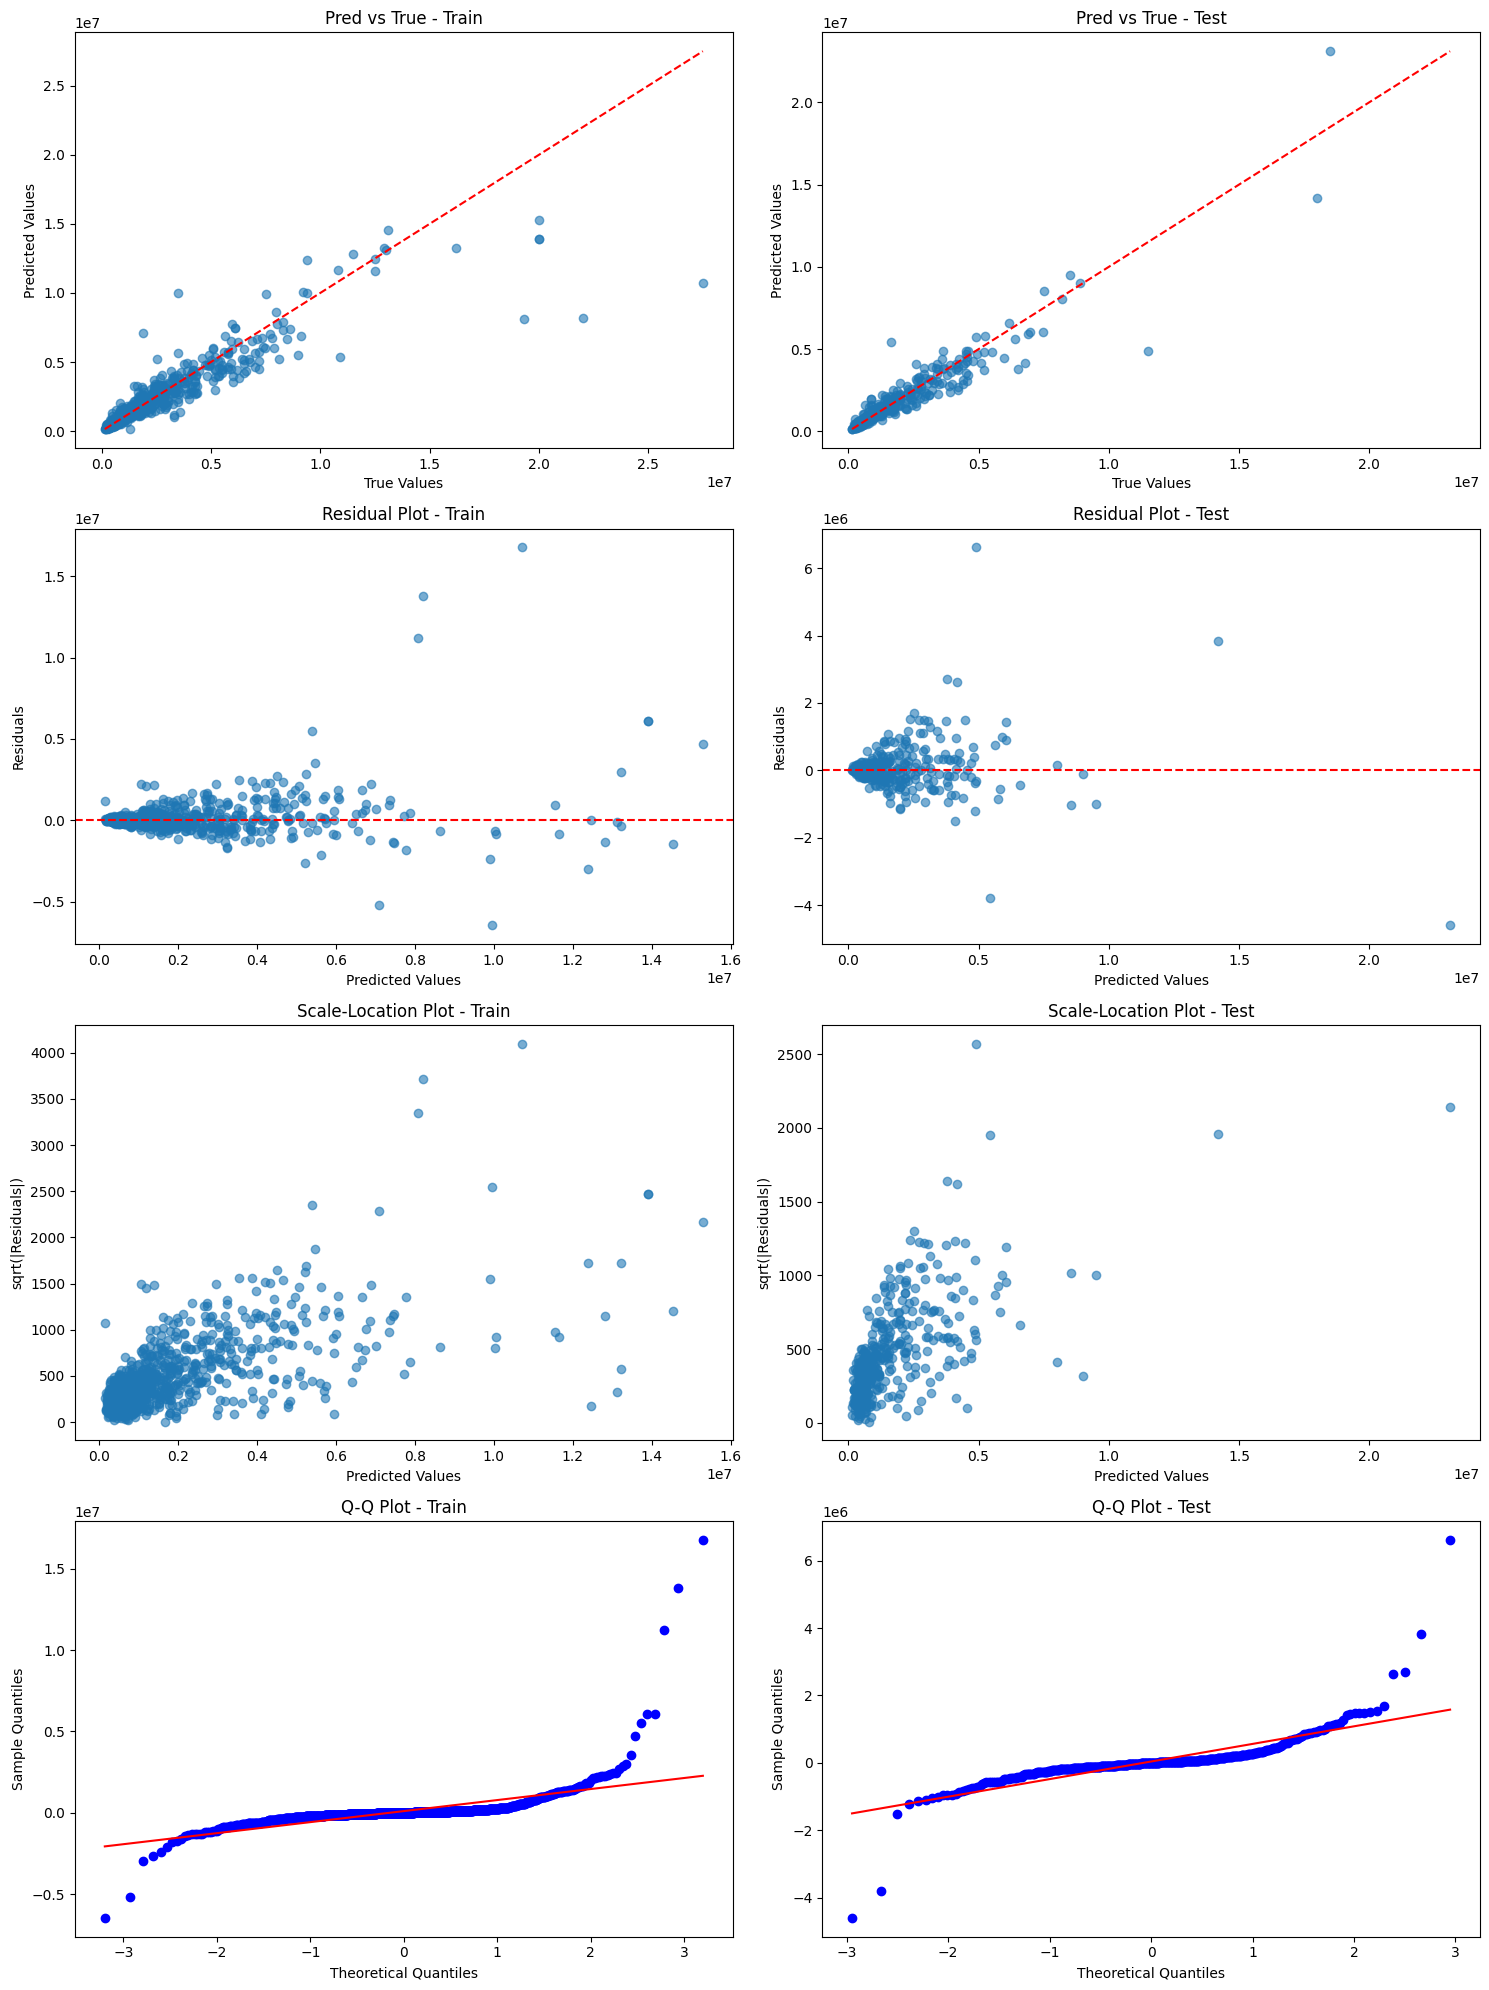

In [14]:
model_testing(auto_selection=True);

#### Insights:
- Thông qua quá trình lựa chọn đặc trưng tự động (backword elimination), mô hình đã loại bỏ 'Owner' và 'Price'
- R² cho tập huấn luyện: 0.829, tập kiểm tra: 0.892
- Mô hình này có hiệu suất gần tương đương với mô hình sử dụng tất cả đặc trưng nhưng đơn giản hơn
- Điều này cho thấy 'Owner' không ảnh hưởng nhiều đến dự đoán giá xe

#### Hồi quy đa thức (Polynomial Regression) bậc 2

$$ y = \beta_0 + \sum_{j=1}^p \beta_j x_j + \sum_{j=1}^p \beta_{j+p} x_j^2 + ... + \sum_{j=1}^p \beta_{j+(d-1)p} x_j^d + \varepsilon \\ \text{n is the number of predictors and d is the chosen degree of polynomial regression} \\ \overline{1..n} \text{ is the subset of chosed columns by performing feature selection on dataset $D$ (MAE metric)} $$

Best: 365778.41113482305
Eliminated columns: {'Seller Type_Individual^2', 'Engine^2', 'Owner^2', 'Drivetrain_FWD^2', 'Max Torque Nm^2', 'Height^2', 'Seller Type_Corporate^2', 'Max Power BHP^2', 'Price', 'Fuel Type_Petrol^2', 'Max Torque RPM^2', 'Max Power RPM^2', 'Transmission_Manual^2', 'Kilometer^2', 'Year^2', 'Drivetrain_RWD^2', 'Seating Capacity^2', 'Width', 'Fuel Tank Capacity^2', 'Fuel Type_Diesel^2', 'Length^2', 'Width^2', 'Fuel Type_Others^2'}
Chosed columns:  ['Year', 'Kilometer', 'Max Power RPM', 'Max Torque RPM', 'Engine', 'Length', 'Height', 'Fuel Tank Capacity', 'Max Power BHP', 'Max Torque Nm', 'Owner', 'Seating Capacity', 'Drivetrain_FWD', 'Drivetrain_RWD', 'Fuel Type_Diesel', 'Fuel Type_Others', 'Fuel Type_Petrol', 'Seller Type_Corporate', 'Seller Type_Individual', 'Transmission_Manual']
Total columns:  20
Train r^2:  0.8236429816159319
Train MAE:  3.658e+05
Train MSE:  1.131e+12
Train RMSE:  1.063e+06
Test r^2:  0.8727851347560074
Test MAE:  3.143e+05
Test MSE:  4.992e

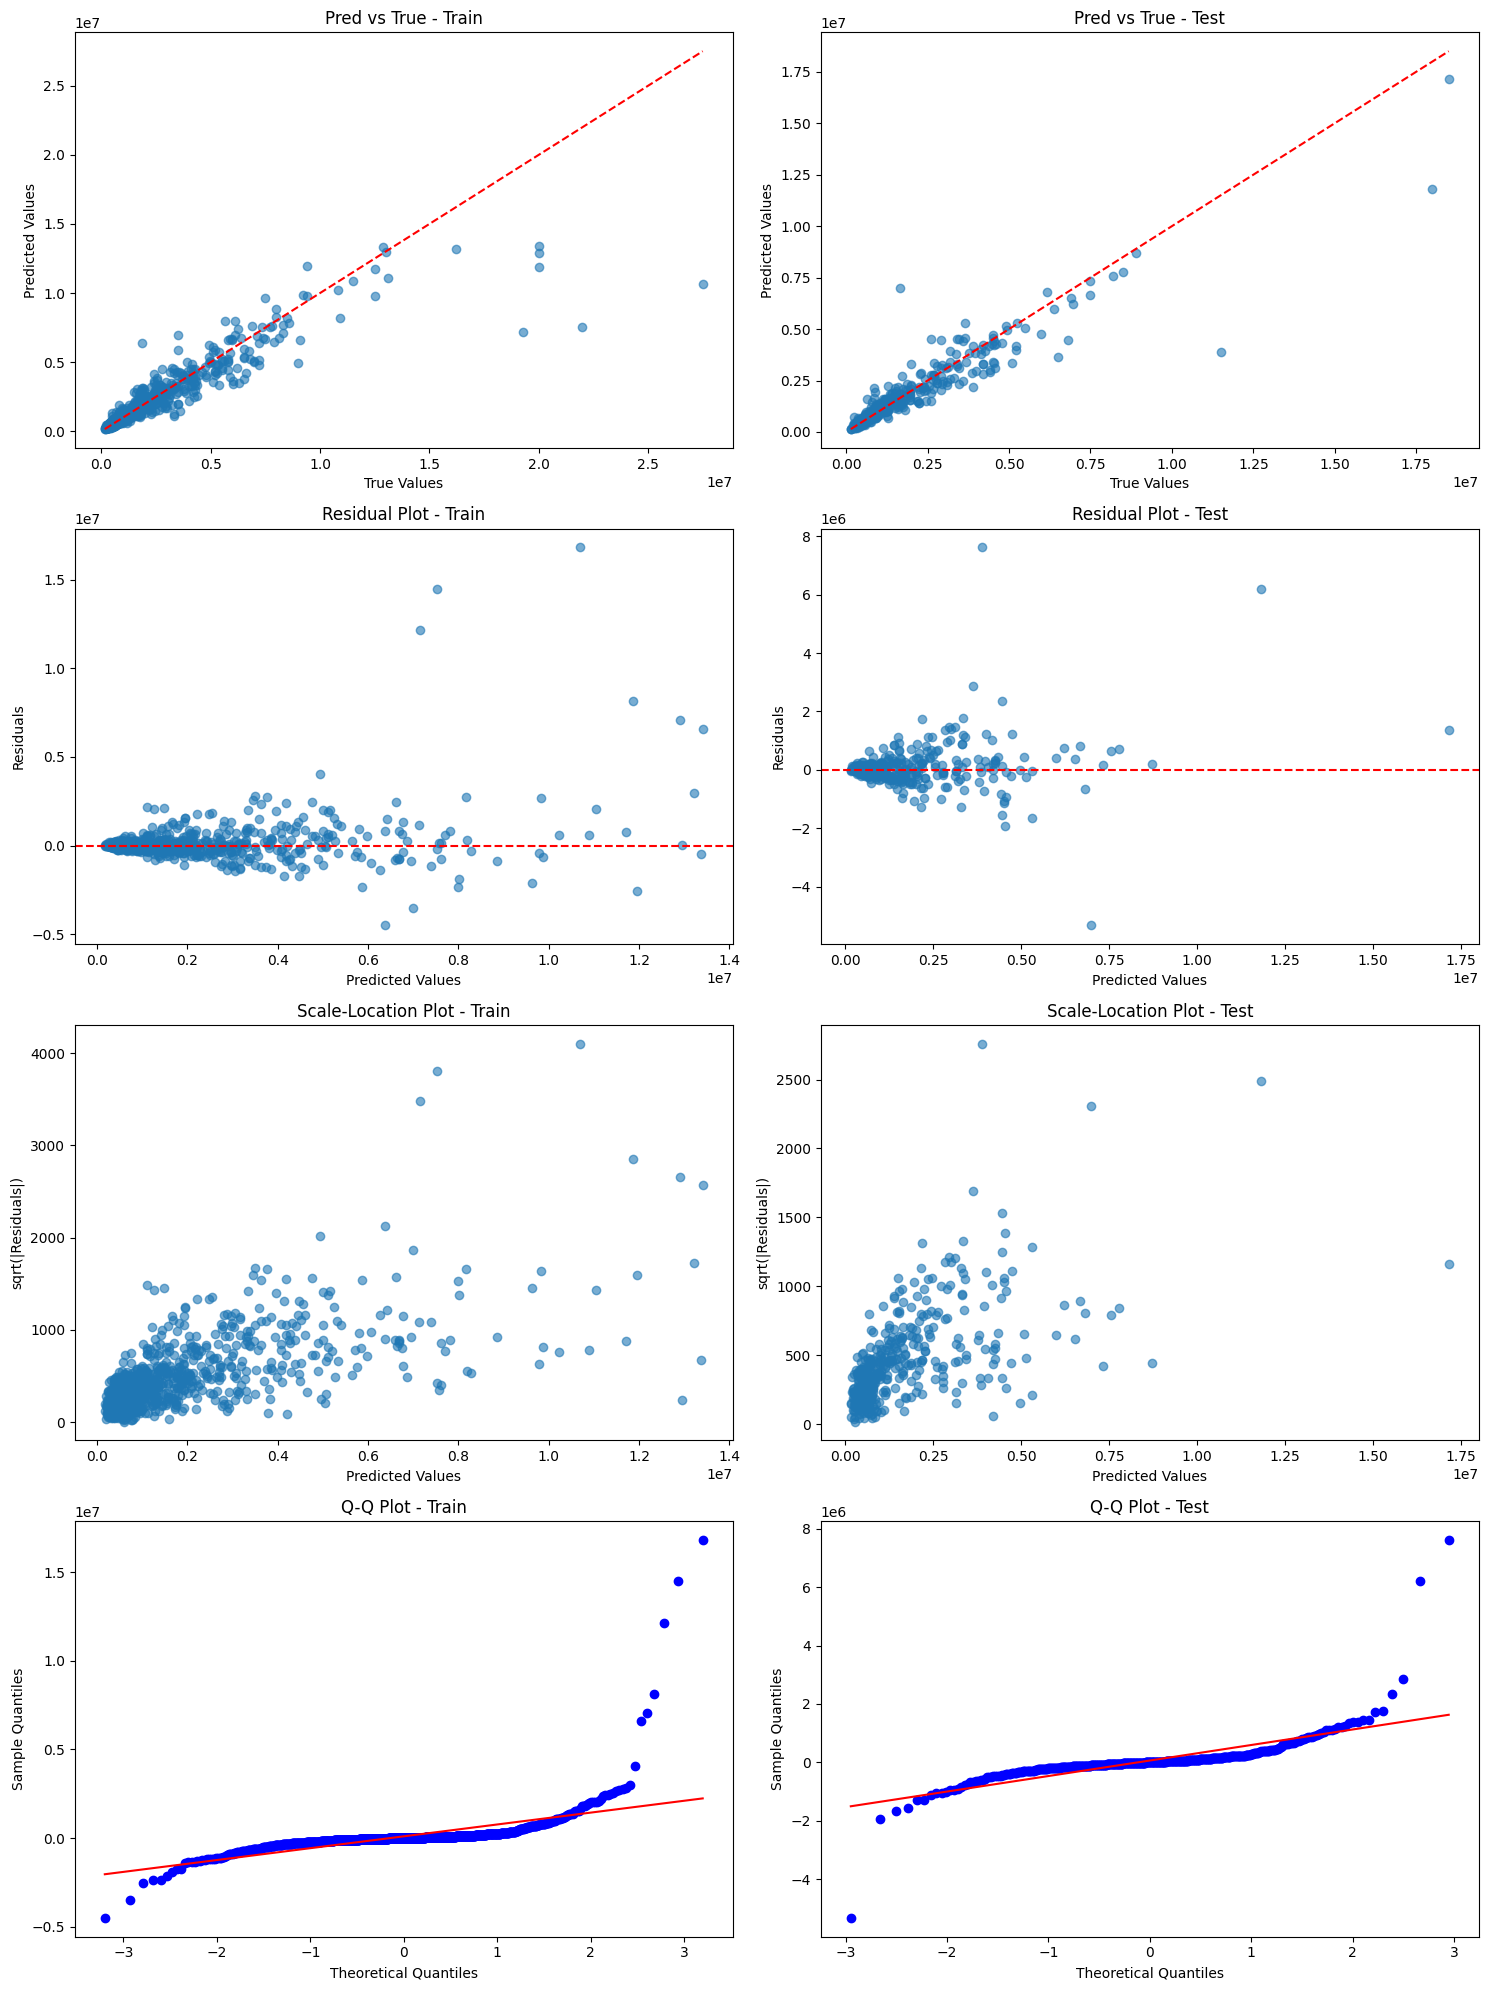

In [15]:
model_testing(linear=False, 
        deg=2,
        auto_selection=True, 
        model_type=PolynomialRegression);

#### Insights:
- Mô hình hồi quy đa thức bậc 2 đã loại bỏ nhiều đặc trưng không cần thiết (các biến bậc 2)
- R² cho tập huấn luyện: 0.824, tập kiểm tra: 0.873
- Mô hình này có hiệu suất tốt nhưng không cải thiện đáng kể so với hồi quy tuyến tính
- Phân phối phần dư (residuals) khá đồng đều, cho thấy mô hình phù hợp với dữ liệu

#### Hồi quy hỗn hợp (Mixed Regression) với các đặc trưng tương tác

$$ y = \beta_0 + \sum_{j=1}^{p} \beta_j x_j + \sum_{j=1}^{p} \sum_{d=2}^D \beta_{jd} x_j^d + \sum_{j=1}^{p} \sum_{k>j}^{p} \beta_{jk} (x_j \times x_k) + \varepsilon \\ \varepsilon : \text{Error term (residuals) - Represents the unexplained variation} \\ \text{assumed to follow normal distribution with mean 0 and constant variance $\sigma^2$}
\\ p : \text{Number of predictor variables (features) in the dataset}
\\ D : \text{Maximum polynomial degree considered in the model (controlled by self.degree in the code)} $$

Best: 222718.3441881698
Eliminated columns: {'Seller Type_Individual^2', 'Kilometer*Max Torque Nm', 'Max Power BHP*Drivetrain_RWD', 'Width*Fuel Type_Diesel', 'Max Power BHP*Max Torque Nm', 'Owner^2', 'Max Power BHP*Fuel Type_Petrol', 'Length*Fuel Tank Capacity', 'Height*Fuel Tank Capacity', 'Drivetrain_FWD^2', 'Engine*Fuel Type_Others', 'Width*Seating Capacity', 'Year*Transmission_Manual', 'Fuel Tank Capacity*Seller Type_Corporate', 'Width*Fuel Tank Capacity', 'Height*Seller Type_Corporate', 'Seller Type_Corporate^2', 'Engine*Fuel Type_Petrol', 'Height*Transmission_Manual', 'Width*Drivetrain_RWD', 'Max Power BHP*Drivetrain_FWD', 'Year*Width', 'Max Torque Nm*Drivetrain_FWD', 'Drivetrain_FWD*Seller Type_Individual', 'Owner*Fuel Type_Petrol', 'Year*Seller Type_Corporate', 'Owner*Seller Type_Corporate', 'Kilometer*Engine', 'Max Torque RPM^2', 'Max Torque RPM*Seller Type_Individual', 'Max Torque RPM*Seating Capacity', 'Height*Drivetrain_FWD', 'Kilometer*Max Torque RPM', 'Year*Seating Capaci

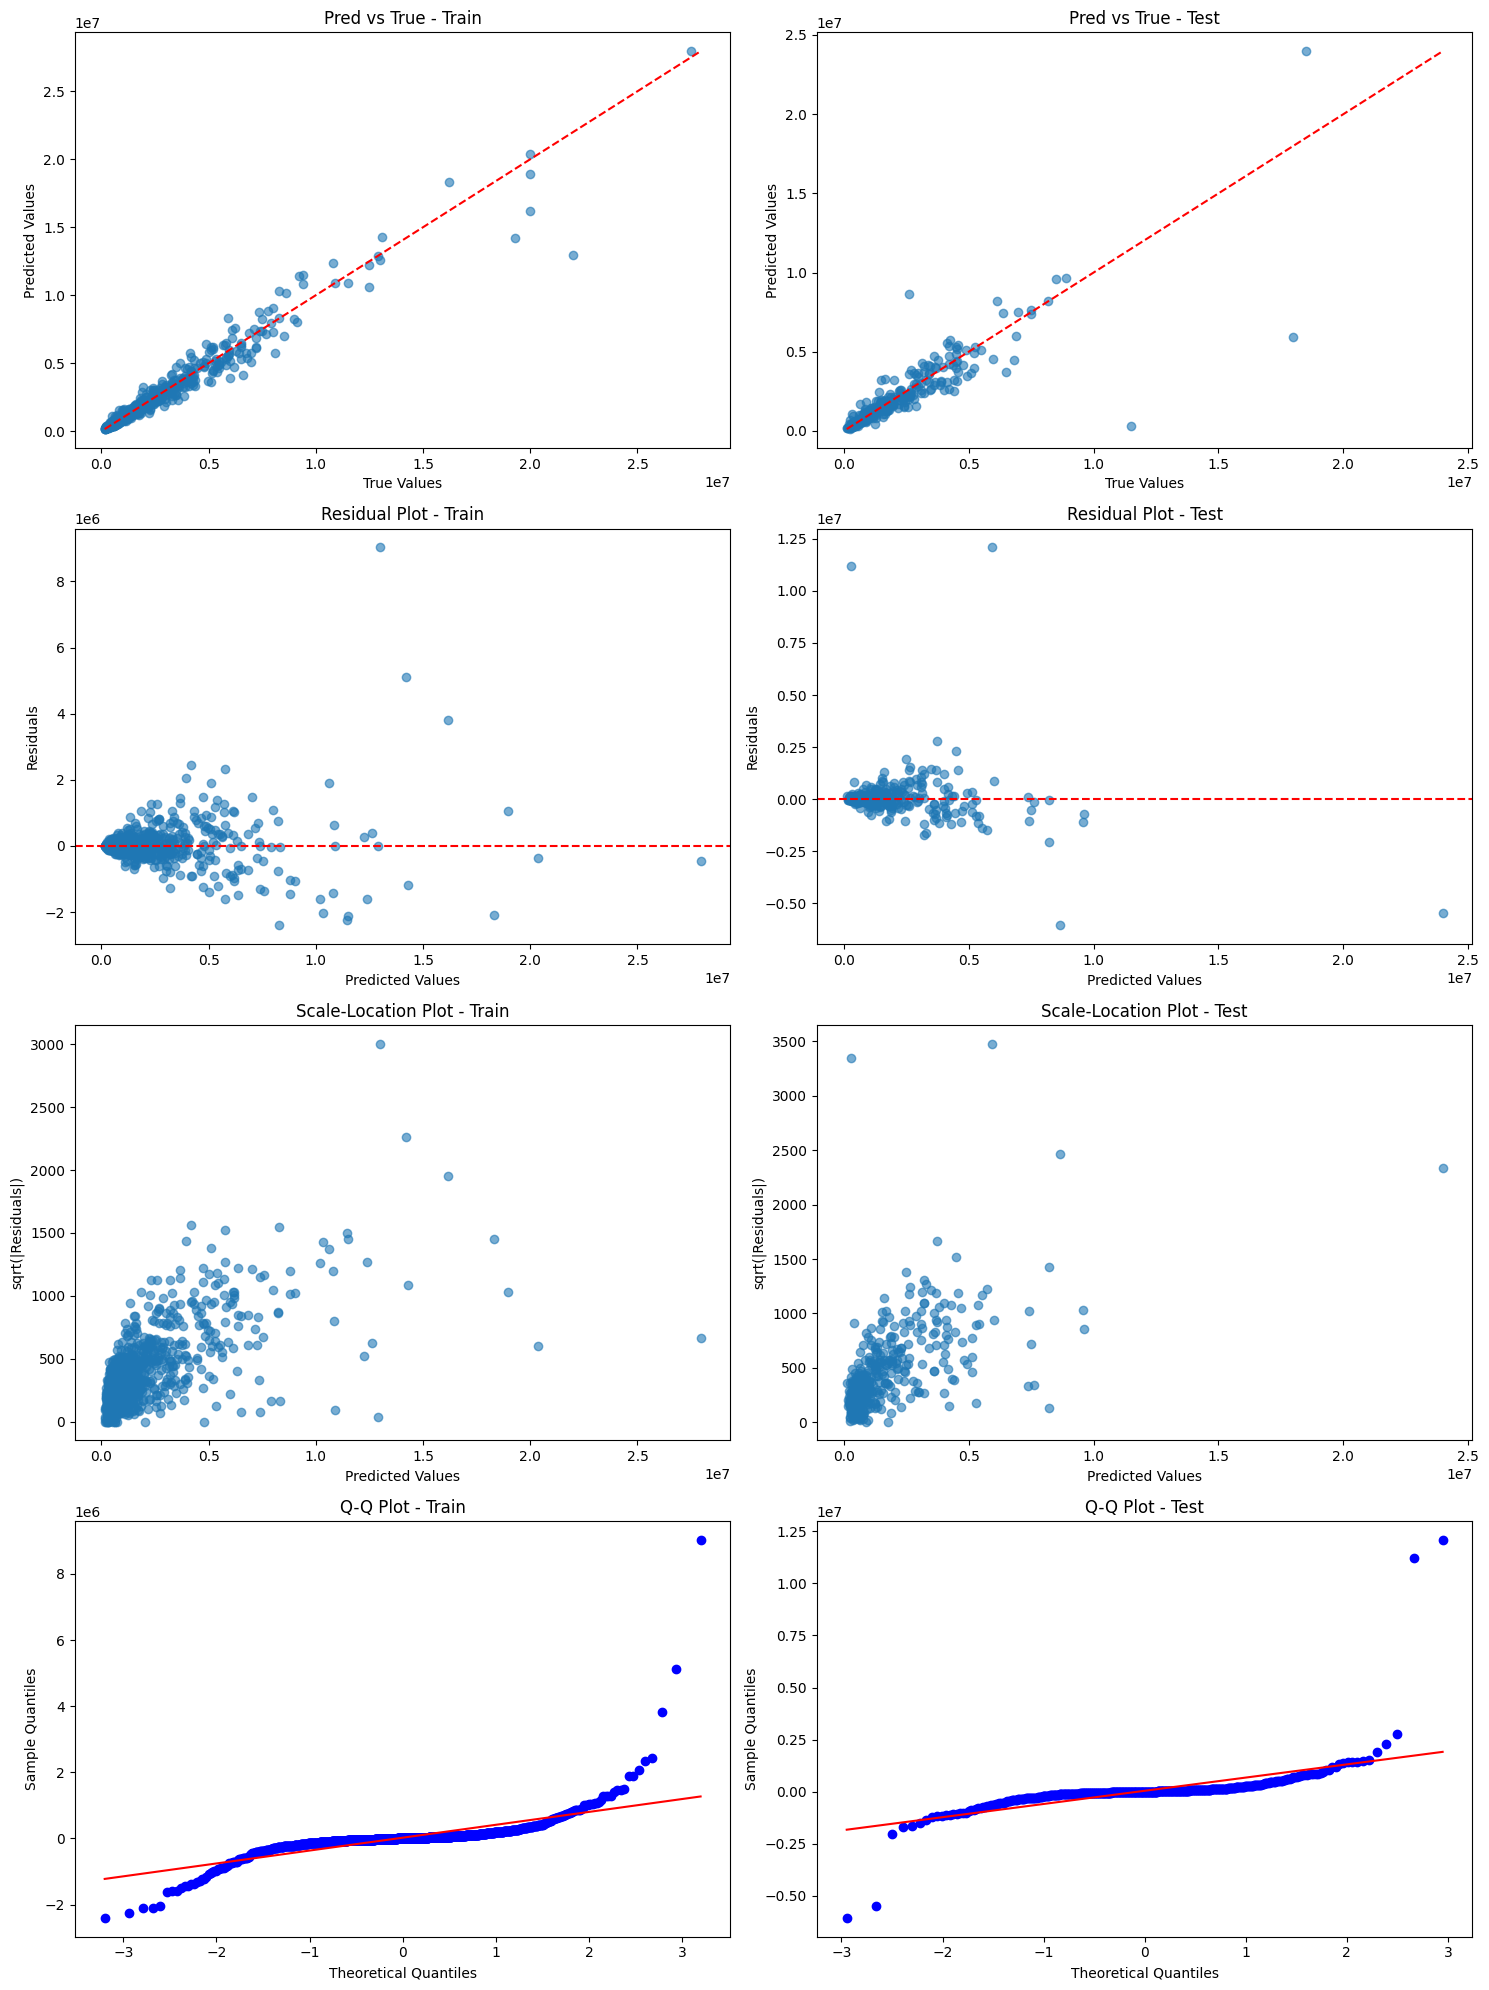

In [16]:
import warnings
from pandas.errors import PerformanceWarning
warnings.filterwarnings("ignore", category=PerformanceWarning)

from modelling.Model import MixedRegression
model_testing(linear=False,
        deg=2,
        auto_selection=True, 
        model_type=MixedRegression);

#### Insights:
- Mô hình hồi quy hỗn hợp tạo ra nhiều đặc trưng tương tác giữa các đặc trưng gốc
- R² cho tập huấn luyện rất cao (0.957) nhưng R² cho tập kiểm tra thấp hơn (0.752)
- Sự chênh lệch lớn giữa hiệu suất trên tập huấn luyện và kiểm tra cho thấy mô hình bị overfitting
- Mặc dù mô hình này phức tạp nhất, nó không phải là mô hình tốt nhất để dự đoán giá xe do vấn đề overfitting

### 3. Chọn mô hình tổng quát nhất cho dự đoán

In [17]:
# all in
subcols = model_testing(auto_selection=True, plot=False)
model.fit(train_df[subcols], train_df['Price'])

Chosed columns:  ['Year', 'Kilometer', 'Max Power RPM', 'Max Torque RPM', 'Engine', 'Length', 'Height', 'Width', 'Fuel Tank Capacity', 'Max Power BHP', 'Max Torque Nm', 'Seating Capacity', 'Drivetrain_FWD', 'Drivetrain_RWD', 'Fuel Type_Diesel', 'Fuel Type_Others', 'Fuel Type_Petrol', 'Seller Type_Corporate', 'Seller Type_Individual', 'Transmission_Manual']
Total columns:  20


#### Insights:
- Sau khi so sánh các mô hình, chúng ta chọn mô hình hồi quy tuyến tính với lựa chọn đặc trưng tự động
- Mô hình này cung cấp sự cân bằng tốt giữa độ chính xác và độ phức tạp
- Các đặc trưng được chọn bao gồm các thông số kỹ thuật quan trọng của xe như năm sản xuất, số km đã đi, công suất động cơ, kích thước xe, v.v.

## IV. Dự đoán trên tập dữ liệu mới

In [ ]:
data_path = 'test.csv'
test_data = pd.read_csv(data_path)
test_data = clean_data(test_data)
# test_data.dropna(inplace=True)
y = test_data['Price']

test_data = preprocessor.transform(test_data)
test_data = pd.DataFrame(test_data, columns=feature_names)

model.predict(test_data[subcols])

y_pred = model.predict(test_data[subcols])
print('Test r^2: ', r2_score(y, y_pred))
print('Test MAE: ', f"{mean_absolute_error(y, y_pred):.3e}")
print('Test MSE: ', f"{mean_squared_error(y, y_pred):.3e}")

Test r^2:  0.8426879732287468
Test MAE:  3.554e+05
Test MSE:  8.919e+11


## Kết luận:

1. **Mô hình tốt nhất**: Hồi quy tuyến tính với lựa chọn đặc trưng tự động là mô hình tốt nhất cho bài toán dự đoán giá xe cũ
2. **Đặc trưng quan trọng**: Các đặc trưng quan trọng nhất bao gồm năm sản xuất, số km đã đi, công suất động cơ, kích thước xe, loại nhiên liệu, và hệ dẫn động
3. **Hiệu suất mô hình**: Mô hình có R² xấp xỉ 0.84 trên tập dữ liệu kiểm tra, cho thấy khả năng dự đoán tốt
4. **Hạn chế**: Mô hình hồi quy đa thức và hỗn hợp không cải thiện đáng kể hiệu suất, thậm chí mô hình hỗn hợp còn bị overfitting

Mô hình hồi quy tuyến tính với lựa chọn đặc trưng tự động là sự lựa chọn phù hợp nhất cho bài toán này vì nó cung cấp sự cân bằng tốt giữa độ chính xác và độ phức tạp.